# **Imports**

Before we start, I would like to say *Thank you* to the author of [this](https://github.com/renatofillinich/ab_test_guide_in_python/blob/master/AB%20testing%20with%20Python.ipynb) notebook!

In [897]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

sns.set_theme(style="whitegrid", palette="muted")
plt.rc('patch', edgecolor='black')
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 1.5})

# **Downloading and exploring the data**

In [898]:
df = pd.read_csv('../input/ab-testing/ab_data.csv')

df.sample(10)

,user_id,timestamp,group,landing_page,converted
137874,846985,2017-01-23 05:24:29.494754,treatment,old_page,1
252885,870665,2017-01-10 03:53:05.685305,control,old_page,0
223540,748254,2017-01-11 13:08:25.136300,treatment,new_page,0
31688,853746,2017-01-12 23:00:40.716064,treatment,new_page,0
24890,671315,2017-01-20 19:11:43.484560,control,old_page,0
101035,882466,2017-01-19 15:24:14.527413,control,old_page,1
121616,896381,2017-01-20 19:47:06.495295,treatment,new_page,1
130809,689416,2017-01-15 08:57:12.521874,treatment,new_page,0
177512,649774,2017-01-12 05:10:26.599968,treatment,new_page,1
149211,653044,2017-01-13 00:42:49.187655,treatment,new_page,0


In [899]:
df.shape

(294478, 5)

In [900]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [901]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [902]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [903]:
df.columns.tolist()

['user_id', 'timestamp', 'group', 'landing_page', 'converted']

We see, that there are 5 columns:
* '**user_id**' contains user ids
* '**timestamp**' is about when a session was
* '**group**' contains 2 variables: control and treatment
* '**landing_page**' is about what version of a site a user saw
* '**converted**' says us about user's behavior: if a user made a purchase (1) or not (0)

In [904]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


# **Power analysis**

* To provide an analysis of an A/B-test, **let assume, that the conversion (number of purchases/number of visits) in our company was 12%. We would like to increase this number to 14%.** Therefore, we created A/B-test to ensure that a new version of a site will certainly increase the conversion.

* To decide what number of people we need to prove/reject the hypothesis, we have to conduct a power analysis.

In [905]:
effect_size = sms.proportion_effectsize(0.12, 0.14)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.9,  #power of a test (defualt is 0.8)
    alpha=0.05, #p-value
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

5934


Therefore, we need **5134 users in control** and **5134 users in treatment** group.

# **Choosing users for each group**

In [906]:
df[['user_id', 'timestamp']].nunique()

user_id      290584
timestamp    294478
dtype: int64

In [907]:
df.user_id.value_counts()

805339    2
754884    2
722274    2
783176    2
898232    2
         ..
642985    1
771499    1
923606    1
712675    1
715931    1
Name: user_id, Length: 290584, dtype: int64

Some of the users occur in the dataset more than once. As we have 294478 rows and we need only 10268 of them, let's simply drop the doubles.

In [908]:
session_counts = df.user_id.value_counts()
double_users = session_counts[session_counts>1].index

double_users

Int64Index([805339, 754884, 722274, 783176, 898232, 899018, 904570, 842042,
            881123, 858720,
            ...
            721188, 902463, 713355, 827417, 655283, 847058, 889392, 664150,
            835401, 736955],
           dtype='int64', length=3894)

In [909]:
df['user_id'].isin(double_users).value_counts()

False    286690
True       7788
Name: user_id, dtype: int64

In [910]:
df = df[~df['user_id'].isin(double_users)]
df.shape

(286690, 5)

In [911]:
control_group = df.query('group == "control"').sample(required_n)
treatment_group = df.query('group == "treatment"').sample(required_n)

In [912]:
control_group.head()

,user_id,timestamp,group,landing_page,converted
7054,653109,2017-01-05 05:28:54.742331,control,old_page,0
243442,700313,2017-01-18 22:33:45.305552,control,old_page,0
170269,676257,2017-01-12 01:24:02.048681,control,old_page,0
254077,640559,2017-01-12 05:47:12.124736,control,old_page,0
91715,901648,2017-01-06 18:34:17.688590,control,old_page,0


In [913]:
treatment_group.head()

,user_id,timestamp,group,landing_page,converted
272315,819187,2017-01-04 19:39:05.273934,treatment,new_page,0
45585,727027,2017-01-05 03:54:13.257113,treatment,new_page,0
51251,925658,2017-01-08 21:08:49.557407,treatment,new_page,0
3532,861467,2017-01-16 11:47:29.609005,treatment,new_page,0
200702,661974,2017-01-22 06:16:19.762204,treatment,new_page,0


In [914]:
ab_test = pd.concat([control_group, treatment_group], axis=0)
ab_test.reset_index(inplace=True, drop=True)

In [915]:
ab_test.head()

,user_id,timestamp,group,landing_page,converted
0,653109,2017-01-05 05:28:54.742331,control,old_page,0
1,700313,2017-01-18 22:33:45.305552,control,old_page,0
2,676257,2017-01-12 01:24:02.048681,control,old_page,0
3,640559,2017-01-12 05:47:12.124736,control,old_page,0
4,901648,2017-01-06 18:34:17.688590,control,old_page,0


In [916]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11868 entries, 0 to 11867
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       11868 non-null  int64 
 1   timestamp     11868 non-null  object
 2   group         11868 non-null  object
 3   landing_page  11868 non-null  object
 4   converted     11868 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 463.7+ KB


In [917]:
ab_test.group.value_counts()

control      5934
treatment    5934
Name: group, dtype: int64

In [918]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=1)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=1)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.121,0.326,0.004
treatment,0.124,0.329,0.004


The control group shows us **12.1%** conversion rate and the treatment group **12.4%** conversion rate.

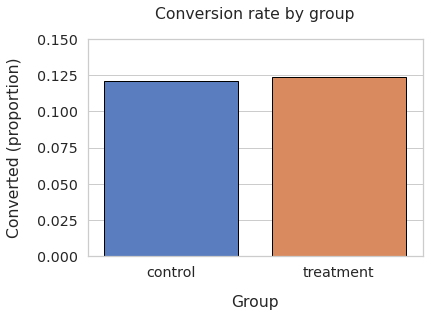

In [919]:
sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.15)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

So, we see a light improvement. Let's decide whether this difference is **statistically significant**.

# **Z-test and confidence intervals**

In [920]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [921]:
control_conversion = ab_test.query('group == "control"')['converted']
treatment_conversion = ab_test.query('group == "treatment"')['converted']

In [922]:
nobs = [control_conversion.count(), treatment_conversion.count()]
successes = [control_conversion.sum(), treatment_conversion.sum()]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'95% Confidence interval for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'95% Confidence interval for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.48
p-value: 0.634
95% Confidence interval for control group: [0.112, 0.129]
95% Confidence interval for treatment group: [0.115, 0.132]


Despite the fact, that from the first sight the conversation rate of the treatment group seemed to be slightly higher, **p-value>0.05 --> we cannot accept the alternative hypothesis**. Besides, the confident intervals include our baseline value of 12% conversion rate.

Therefore, this **new version of the site cannot increase conversion significantly**.
With the results of the A/B-test we came to conclusion, that it makes no sense for the company to introduce a new version of the site.